# Clinician feature sets
The purpose of this notebook is to create the array of clinician-suggested feature sets.

## Imports and  helper functions

In [1]:
%run 'UNSEEN_helper_functions.ipynb'
%store -r

## Load codelist CSV files.
We used opencodelist.org to define codelists that define the set of SNOMED-CT codes used to identify patients based on various attributes.

In [2]:
# Instatiate BigQuery client.
client = bigquery.Client()

# Set folder location.
folder_loc = os.path.dirname(os.path.abspath("UNSEEN_create_clinician_feature_sets.ipynb"))
folder = folder_loc + '/codelists/'

# Clinical codes of interest.
codes_to_query_UPSI = pandas.read_csv(folder + "ciaranmci-unprotected-sexual-intercourse-1c772b8e.csv")
codes_to_query_teenagePregnancy = pandas.read_csv(folder + "ciaranmci-teenage-adolescent-pregnancy-3e52c03a.csv")
codes_to_query_attemptedSuicide = pandas.read_csv(folder + "ciaranmci-attempted-suicide-0367b859.csv")
codes_to_query_selfHarm = pandas.read_csv(folder + "ciaranmci-self-harm-6b0c26b8.csv")
codes_to_query_CAMHSrefsAndDisch = pandas.read_csv(folder + "ciaranmci-camhs-referrals-and-discharges-0e87f47d.csv")
codes_to_query_substanceMisuse = pandas.read_csv(folder + "ciaranmci-substance-misuse-363a8058.csv")
codes_to_query_CYPmentalDisorder = pandas.read_csv(folder + "ciaranmci-child-young-person-mental-disorder-279767b2.csv")
codes_to_query_childAbuse = pandas.read_csv(folder + "ciaranmci-child-abuse-041b99ee.csv")
codes_to_query_familialSubstanceMisuse = pandas.read_csv(folder + "ciaranmci-familial-drug-abuse-and-misuse-3aec1eaf.csv")
codes_to_query_socialServicesInvolved = pandas.read_csv(folder + "ciaranmci-social-services-involved-25434d05.csv")
codes_to_query_childProtection = pandas.read_csv(folder + "ciaranmci-child-protection-13ed7469.csv")
codes_to_query_familialMentalHealthConditions = pandas.read_csv(folder + "ciaranmci-family-history-of-mental-health-conditions-or-suicide-53fb91e4.csv")
codes_to_query_partedParents = pandas.read_csv(folder + "ciaranmci-child-of-single-divorced-or-separated-parents-061a784f.csv")
codes_to_query_depressionNotDysthymiaOrChronic = pandas.read_csv(folder + "ciaranmci-depression-not-chronic-not-dysthymia-782b413d.csv")
codes_to_query_IAPTuse = pandas.read_csv(folder + "ciaranmci-iapt-use-51fcb383.csv")
codes_to_query_anxietyOrPanic = pandas.read_csv(folder + "ciaranmci-anxiety-or-panic-finding-and-disorder-2cfce79e.csv")
codes_to_query_agorophobia = pandas.read_csv(folder + "ciaranmci-agorophobia-67a5852d.csv")
codes_to_query_eatingDisorders = pandas.read_csv(folder + "ciaranmci-eating-disorders-3ba00044.csv")
codes_to_query_poorBodyImage = pandas.read_csv(folder + "ciaranmci-poor-body-image-27422b66.csv")
codes_to_query_CYPneurodevDisorder = pandas.read_csv(folder + "ciaranmci-child-young-person-neurodevelopmental-disorder-59b64e1c.csv")
codes_to_query_ADHD = pandas.read_csv(folder + "ciaranmci-attention-deficit-hyperactivity-disorder-752344fb.csv")
codes_to_query_autism = pandas.read_csv(folder + "nhsd-primary-care-domain-refsets-autism_cod-20210127.csv")
codes_to_query_SpLD = pandas.read_csv(folder + "ciaranmci-dyspraxia-dyscalculia-and-dyslexia-7889e686.csv")
codes_to_query_adultVictimOfAbuse = pandas.read_csv(folder + "ciaranmci-adult-victim-of-abuse-447ef3b5.csv")
codes_to_query_DNA = pandas.read_csv(folder + "ciaranmci-did-not-attend-098119da.csv")
codes_to_query_violentBehaviour = pandas.read_csv(folder + "ciaranmci-violent-behaviour-7071a6a4.csv")
codes_to_query_IAPTreferral = pandas.read_csv(folder + "ciaranmci-iapt-referral-16fed9a8.csv")
codes_to_query_paranoia = pandas.read_csv(folder + "ciaranmci-paranoia-5c690e12.csv")
codes_to_query_auditoryHallucinations = pandas.read_csv(folder + "ciaranmci-auditory-hallucinations-5762336f.csv")
codes_to_query_dissociation = pandas.read_csv(folder + "ciaranmci-dissociation-75788147.csv")
codes_to_query_NESA = pandas.read_csv(folder + "ciaranmci-non-epileptic-seizure-attack-depreciated-pseduoseizure-43599add.csv")
codes_to_query_alcoholMisuse = pandas.read_csv(folder + "ciaranmci-alcohol-misuse-53df56ed.csv")
codes_to_query_drugMisuse = pandas.read_csv(folder + "ciaranmci-drug-misuse-3acfe3b8.csv")

# Medications of interest.
medications_to_query_psychosisAndRelated = pandas.read_csv(folder + "UNSEEN medications_psychosisAndRelated.csv")
medications_to_query_hypnoticsAndAnxiolytics = pandas.read_csv(folder + "UNSEEN medications_hypnoticsAndAnxiolytics.csv")
medications_to_query_alcoholMisuse = pandas.read_csv(folder + "UNSEEN medications indicating treatment for alcohol misuse.csv")
medications_to_query_drugMisuse = pandas.read_csv(folder + "UNSEEN medications indicating treatment for drug misuse.csv")

## Load prerequisites

In [3]:
%%capture
if 'caseness_array' not in globals():
    %run ./"UNSEEN_create_caseness_variables.ipynb"

## Query database for base feature sets
The clinician feature sets are a mix of feature sets that are mostly defined simply by the presence of SNOMED-CT codes, others are made of composites of these simple feature sets, and a few capture patterns of SNOMED-CT codes. The code below returns `fs_clinician` that contains the base feature sets.

In [7]:
sql_CTEs_top = """
WITH
# The first CTE will specify the 'spine' of the data table by selecting the unique list of person IDs.
tbl_persons AS (
    SELECT
        DISTINCT person_id
        ,year_of_birth
    FROM
        """ + server_id + """.""" + database_id + """.person
    # Limiting to age range 18-70.
    WHERE
        (EXTRACT(YEAR FROM CURRENT_DATE()) - year_of_birth) BETWEEN 18 AND 70
)
"""

sql_CTEs_body = \
"""
#  ## Unprotected sexual intercourse
,tbl_UPSI AS ( 
    SELECT
        snomedcode
    FROM
        UNNEST([
                '""" + '\', \''.join(map(str, codes_to_query_UPSI["code"].tolist())) + """'
                ]) AS snomedcode
)
,tbl_UPSI_persons AS (
    SELECT
        DISTINCT person_id
        ,a.snomedcode
        ,a.dateevent
    FROM
        """ + server_id + """.""" + database_id + """.tbl_srcode AS a, tbl_UPSI
    WHERE
        a.snomedcode IN (tbl_UPSI.snomedcode)
)
,tbl_UPSICYP_persons AS (
    SELECT
        DISTINCT tbl_UPSI_persons.person_id
        ,snomedcode
    FROM tbl_persons
    LEFT OUTER JOIN tbl_UPSI_persons ON tbl_persons.person_id = tbl_UPSI_persons.person_id
    WHERE (EXTRACT(YEAR FROM tbl_UPSI_persons.dateevent) - tbl_persons.year_of_birth) < 19
)
#  ## Teenage pregnancy
,tbl_teenagePregnancy AS ( 
    SELECT
        snomedcode
    FROM
        UNNEST([
                '""" + '\', \''.join(map(str, codes_to_query_teenagePregnancy["code"].tolist())) + """'
                ]) AS snomedcode
)
,tbl_teenagePregnancy_persons AS (
    SELECT
        DISTINCT person_id
        ,a.snomedcode
        ,a.dateevent
    FROM
        """ + server_id + """.""" + database_id + """.tbl_srcode AS a, tbl_teenagePregnancy
    WHERE
        a.snomedcode IN (tbl_teenagePregnancy.snomedcode)
)
,tbl_teenagePregnancyCYP_persons AS (
    SELECT
        DISTINCT tbl_teenagePregnancy_persons.person_id
        ,snomedcode
    FROM tbl_persons
    LEFT OUTER JOIN tbl_teenagePregnancy_persons ON tbl_persons.person_id = tbl_teenagePregnancy_persons.person_id
    WHERE (EXTRACT(YEAR FROM tbl_teenagePregnancy_persons.dateevent) - tbl_persons.year_of_birth) < 19
)
#  ## Attempted Suicide
,tbl_attemptedSuicide AS ( 
    SELECT
        snomedcode
    FROM
        UNNEST([
                '""" + '\', \''.join(map(str, codes_to_query_attemptedSuicide["code"].tolist())) + """'
                ]) AS snomedcode
)
,tbl_attemptedSuicide_persons AS (
    SELECT
        DISTINCT person_id
        ,a.snomedcode
        ,a.dateevent
    FROM
        """ + server_id + """.""" + database_id + """.tbl_srcode AS a, tbl_attemptedSuicide
    WHERE
        a.snomedcode IN (tbl_attemptedSuicide.snomedcode)
)
,tbl_attemptedSuicideCYP_persons AS (
    SELECT
        DISTINCT tbl_attemptedSuicide_persons.person_id
        ,snomedcode
    FROM tbl_persons
    LEFT OUTER JOIN tbl_attemptedSuicide_persons ON tbl_persons.person_id = tbl_attemptedSuicide_persons.person_id
    WHERE (EXTRACT(YEAR FROM tbl_attemptedSuicide_persons.dateevent) - tbl_persons.year_of_birth) < 19
)
#  ## Self harm
,tbl_selfHarm AS ( 
    SELECT
        snomedcode
    FROM
        UNNEST([
                '""" + '\', \''.join(map(str, codes_to_query_selfHarm["code"].tolist())) + """'
                ]) AS snomedcode
)
,tbl_selfHarm_persons AS (
    SELECT
        DISTINCT person_id
        ,a.snomedcode
        ,a.dateevent
    FROM
        """ + server_id + """.""" + database_id + """.tbl_srcode AS a, tbl_selfHarm
    WHERE
        a.snomedcode IN (tbl_selfHarm.snomedcode)
)
,tbl_selfHarmCYP_persons AS (
    SELECT
        DISTINCT tbl_selfHarm_persons.person_id
        ,snomedcode
    FROM tbl_persons
    LEFT OUTER JOIN tbl_selfHarm_persons ON tbl_persons.person_id = tbl_selfHarm_persons.person_id
    WHERE (EXTRACT(YEAR FROM tbl_selfHarm_persons.dateevent) - tbl_persons.year_of_birth) < 19
)
#  ## CAMHS referrals and Discharges.
,tbl_CAMHSrefsAndDisch AS ( 
    SELECT
        snomedcode
    FROM
        UNNEST([
                '""" + '\', \''.join(map(str, codes_to_query_CAMHSrefsAndDisch["code"].tolist())) + """'
                ]) AS snomedcode
)
,tbl_CAMHSrefsAndDisch_persons AS (
    SELECT
        DISTINCT person_id
        ,a.snomedcode
    FROM
        """ + server_id + """.""" + database_id + """.tbl_srcode AS a, tbl_CAMHSrefsAndDisch
    WHERE
        a.snomedcode IN (tbl_CAMHSrefsAndDisch.snomedcode)
)
# ## IAPT revolving door.
,tbl_IAPTrevolvingDoor AS (
    SELECT
        DISTINCT person_id
        ,snomedcode
        ,COUNT(snomedcode) AS n_occurrences
    FROM
        """ + server_id + """.""" + database_id + """.tbl_srcode
    WHERE
        snomedcode IN ('747821000000108')
    GROUP BY
        person_id, snomedcode
)
,tbl_IAPTrevolvingDoor_persons AS (
    SELECT
        DISTINCT person_id
        ,snomedcode
    FROM
        tbl_IAPTrevolvingDoor
    WHERE
        n_occurrences > 1
)
#  ## Substance misuse.
,tbl_substanceMisuse AS ( 
    SELECT
        snomedcode
    FROM
        UNNEST([
                '""" + '\', \''.join(map(str, codes_to_query_substanceMisuse["code"].tolist())) + """'
                ]) AS snomedcode
)
,tbl_substanceMisuse_persons AS (
    SELECT
        DISTINCT person_id
        ,a.snomedcode
        ,a.dateevent
    FROM
        """ + server_id + """.""" + database_id + """.tbl_srcode AS a, tbl_substanceMisuse
    WHERE
        a.snomedcode IN (tbl_substanceMisuse.snomedcode)
)
,tbl_substanceMisuseAdult_persons AS (
    SELECT
        DISTINCT tbl_substanceMisuse_persons.person_id
        ,snomedcode
    FROM tbl_persons
    LEFT OUTER JOIN tbl_substanceMisuse_persons ON tbl_persons.person_id = tbl_substanceMisuse_persons.person_id
    WHERE (EXTRACT(YEAR FROM tbl_substanceMisuse_persons.dateevent) - tbl_persons.year_of_birth) > 18
)
,tbl_substanceMisuseCYP_persons AS (
    SELECT
        DISTINCT tbl_substanceMisuse_persons.person_id
        ,snomedcode
    FROM tbl_persons
    LEFT OUTER JOIN tbl_substanceMisuse_persons ON tbl_persons.person_id = tbl_substanceMisuse_persons.person_id
    WHERE (EXTRACT(YEAR FROM tbl_substanceMisuse_persons.dateevent) - tbl_persons.year_of_birth) < 19
)
#  ## Child or young person mental disorder
,tbl_CYPmentalDisorder AS ( 
    SELECT
        snomedcode
    FROM
        UNNEST([
                '""" + '\', \''.join(map(str, codes_to_query_CYPmentalDisorder["code"].tolist())) + """'
                ]) AS snomedcode
)
,tbl_CYPmentalDisorder_persons AS (
    SELECT
        DISTINCT person_id
        ,a.snomedcode
    FROM
        """ + server_id + """.""" + database_id + """.tbl_srcode AS a, tbl_CYPmentalDisorder
    WHERE
        a.snomedcode IN (tbl_CYPmentalDisorder.snomedcode)
)
#  ## Child abuse
,tbl_childAbuse AS ( 
    SELECT
        snomedcode
    FROM
        UNNEST([
                '""" + '\', \''.join(map(str, codes_to_query_childAbuse["code"].tolist())) + """'
                ]) AS snomedcode
)
,tbl_childAbuse_persons AS (
    SELECT
        DISTINCT person_id
        ,a.snomedcode
    FROM
        """ + server_id + """.""" + database_id + """.tbl_srcode AS a, tbl_childAbuse
    WHERE
        a.snomedcode IN (tbl_childAbuse.snomedcode)
)
#  ## Familial substance misuse
,tbl_familialSubstanceMisuse AS ( 
    SELECT
        snomedcode
    FROM
        UNNEST([
                '""" + '\', \''.join(map(str, codes_to_query_familialSubstanceMisuse["code"].tolist())) + """'
                ]) AS snomedcode
)
,tbl_familialSubstanceMisuse_persons AS (
    SELECT
        DISTINCT person_id
        ,a.snomedcode
    FROM
        """ + server_id + """.""" + database_id + """.tbl_srcode AS a, tbl_familialSubstanceMisuse
    WHERE
        a.snomedcode IN (tbl_familialSubstanceMisuse.snomedcode)
)
#  ## Social services involved
,tbl_socialServicesInvolved AS ( 
    SELECT
        snomedcode
    FROM
        UNNEST([
                '""" + '\', \''.join(map(str, codes_to_query_socialServicesInvolved["code"].tolist())) + """'
                ]) AS snomedcode
)
,tbl_socialServicesInvolved_persons AS (
    SELECT
        DISTINCT person_id
        ,a.snomedcode
    FROM
        """ + server_id + """.""" + database_id + """.tbl_srcode AS a, tbl_socialServicesInvolved
    WHERE
        a.snomedcode IN (tbl_socialServicesInvolved.snomedcode)
)
#  ## Child protection
,tbl_childProtection AS ( 
    SELECT
        snomedcode
    FROM
        UNNEST([
                '""" + '\', \''.join(map(str, codes_to_query_childProtection["code"].tolist())) + """'
                ]) AS snomedcode
)
,tbl_childProtection_persons AS (
    SELECT
        DISTINCT person_id
        ,a.snomedcode
    FROM
        """ + server_id + """.""" + database_id + """.tbl_srcode AS a, tbl_childProtection
    WHERE
        a.snomedcode IN (tbl_childProtection.snomedcode)
)
#  ## Family history of mental health conditions or suicide
,tbl_familialMentalHealthConditions AS ( 
    SELECT
        snomedcode
    FROM
        UNNEST([
                '""" + '\', \''.join(map(str, codes_to_query_familialMentalHealthConditions["code"].tolist())) + """'
                ]) AS snomedcode
)
,tbl_familialMentalHealthConditions_persons AS (
    SELECT
        DISTINCT person_id
        ,a.snomedcode
    FROM
        """ + server_id + """.""" + database_id + """.tbl_srcode AS a, tbl_familialMentalHealthConditions
    WHERE
        a.snomedcode IN (tbl_familialMentalHealthConditions.snomedcode)
)
#  ## Child of single divorced or separated parents
,tbl_partedParents AS ( 
    SELECT
        snomedcode
    FROM
        UNNEST([
                '""" + '\', \''.join(map(str, codes_to_query_partedParents["code"].tolist())) + """'
                ]) AS snomedcode
)
,tbl_partedParents_persons AS (
    SELECT
        DISTINCT person_id
        ,a.snomedcode
    FROM
        """ + server_id + """.""" + database_id + """.tbl_srcode AS a, tbl_partedParents
    WHERE
        a.snomedcode IN (tbl_partedParents.snomedcode)
)
#  ## Depression that is not dysthymia or chronic depression
,tbl_depressionNotDysthymiaOrChronic AS ( 
    SELECT
        snomedcode
    FROM
        UNNEST([
                '""" + '\', \''.join(map(str, codes_to_query_depressionNotDysthymiaOrChronic["code"].tolist())) + """'
                ]) AS snomedcode
)
,tbl_depressionNotDysthymiaOrChronic_persons AS (
    SELECT
        DISTINCT person_id
        ,a.snomedcode
    FROM
        """ + server_id + """.""" + database_id + """.tbl_srcode AS a, tbl_depressionNotDysthymiaOrChronic
    WHERE
        a.snomedcode IN (tbl_depressionNotDysthymiaOrChronic.snomedcode)
)
#  ## IAPT use
,tbl_IAPTuse AS ( 
    SELECT
        snomedcode
    FROM
        UNNEST([
                '""" + '\', \''.join(map(str, codes_to_query_IAPTuse["code"].tolist())) + """'
                ]) AS snomedcode
)
,tbl_IAPTuse_persons AS (
    SELECT
        DISTINCT person_id
        ,a.snomedcode
    FROM
        """ + server_id + """.""" + database_id + """.tbl_srcode AS a, tbl_IAPTuse
    WHERE
        a.snomedcode IN (tbl_IAPTuse.snomedcode)
)
#  ## Anxiety or panic
,tbl_anxietyOrPanic AS ( 
    SELECT
        snomedcode
    FROM
        UNNEST([
                '""" + '\', \''.join(map(str, codes_to_query_anxietyOrPanic["code"].tolist())) + """'
                ]) AS snomedcode
)
,tbl_anxietyOrPanic_persons AS (
    SELECT
        DISTINCT person_id
        ,a.snomedcode
    FROM
        """ + server_id + """.""" + database_id + """.tbl_srcode AS a, tbl_anxietyOrPanic
    WHERE
        a.snomedcode IN (tbl_anxietyOrPanic.snomedcode)
)
#  ## Agorophobia
,tbl_agorophobia AS ( 
    SELECT
        snomedcode
    FROM
        UNNEST([
                '""" + '\', \''.join(map(str, codes_to_query_agorophobia["code"].tolist())) + """'
                ]) AS snomedcode
)
,tbl_agorophobia_persons AS (
    SELECT
        DISTINCT person_id
        ,a.snomedcode
    FROM
        """ + server_id + """.""" + database_id + """.tbl_srcode AS a, tbl_agorophobia
    WHERE
        a.snomedcode IN (tbl_agorophobia.snomedcode)
)
#  ## Eating disorders
,tbl_eatingDisorders AS ( 
    SELECT
        snomedcode
    FROM
        UNNEST([
                '""" + '\', \''.join(map(str, codes_to_query_eatingDisorders["code"].tolist())) + """'
                ]) AS snomedcode
)
,tbl_eatingDisorders_persons AS (
    SELECT
        DISTINCT person_id
        ,a.snomedcode
    FROM
        """ + server_id + """.""" + database_id + """.tbl_srcode AS a, tbl_eatingDisorders
    WHERE
        a.snomedcode IN (tbl_eatingDisorders.snomedcode)
)
#  ## poorBodyImage
,tbl_poorBodyImage AS ( 
    SELECT
        snomedcode
    FROM
        UNNEST([
                '""" + '\', \''.join(map(str, codes_to_query_poorBodyImage["code"].tolist())) + """'
                ]) AS snomedcode
)
,tbl_poorBodyImage_persons AS (
    SELECT
        DISTINCT person_id
        ,a.snomedcode
    FROM
        """ + server_id + """.""" + database_id + """.tbl_srcode AS a, tbl_poorBodyImage
    WHERE
        a.snomedcode IN (tbl_poorBodyImage.snomedcode)
)
#  ## Child or young person neurodevelopmental disorder
,tbl_CYPneurodevDisorder AS ( 
    SELECT
        snomedcode
    FROM
        UNNEST([
                '""" + '\', \''.join(map(str, codes_to_query_CYPneurodevDisorder["code"].tolist())) + """'
                ]) AS snomedcode
)
,tbl_CYPneurodevDisorder_persons AS (
    SELECT
        DISTINCT person_id
        ,a.snomedcode
    FROM
        """ + server_id + """.""" + database_id + """.tbl_srcode AS a, tbl_CYPneurodevDisorder
    WHERE
        a.snomedcode IN (tbl_CYPneurodevDisorder.snomedcode)
)
#  ## ADHD
,tbl_ADHD AS ( 
    SELECT
        snomedcode
    FROM
        UNNEST([
                '""" + '\', \''.join(map(str, codes_to_query_ADHD["code"].tolist())) + """'
                ]) AS snomedcode
)
,tbl_ADHD_persons AS (
    SELECT
        DISTINCT person_id
        ,a.snomedcode
    FROM
        """ + server_id + """.""" + database_id + """.tbl_srcode AS a, tbl_ADHD
    WHERE
        a.snomedcode IN (tbl_ADHD.snomedcode)
)
#  ## Autism
,tbl_autism AS ( 
    SELECT
        snomedcode
    FROM
        UNNEST([
                '""" + '\', \''.join(map(str, codes_to_query_autism["code"].tolist())) + """'
                ]) AS snomedcode
)
,tbl_autism_persons AS (
    SELECT
        DISTINCT person_id
        ,a.snomedcode
    FROM
        """ + server_id + """.""" + database_id + """.tbl_srcode AS a, tbl_autism
    WHERE
        a.snomedcode IN (tbl_autism.snomedcode)
)
#  ## Special learning difficulties
,tbl_SpLD AS ( 
    SELECT
        snomedcode
    FROM
        UNNEST([
                '""" + '\', \''.join(map(str, codes_to_query_SpLD["code"].tolist())) + """'
                ]) AS snomedcode
)
,tbl_SpLD_persons AS (
    SELECT
        DISTINCT person_id
        ,a.snomedcode
    FROM
        """ + server_id + """.""" + database_id + """.tbl_srcode AS a, tbl_SpLD
    WHERE
        a.snomedcode IN (tbl_SpLD.snomedcode)
)
#  ## adultVictimOfAbuse
,tbl_adultVictimOfAbuse AS ( 
    SELECT
        snomedcode
    FROM
        UNNEST([
                '""" + '\', \''.join(map(str, codes_to_query_adultVictimOfAbuse["code"].tolist())) + """'
                ]) AS snomedcode
)
,tbl_adultVictimOfAbuse_persons AS (
    SELECT
        DISTINCT person_id
        ,a.snomedcode
    FROM
        """ + server_id + """.""" + database_id + """.tbl_srcode AS a, tbl_adultVictimOfAbuse
    WHERE
        a.snomedcode IN (tbl_adultVictimOfAbuse.snomedcode)
)
#  ## Many Did-Not-Attend (DNA)
,tbl_manyDNA AS ( 
    SELECT
        snomedcode
    FROM
        UNNEST([
                '""" + '\', \''.join(map(str, codes_to_query_DNA["code"].tolist())) + """'
                ]) AS snomedcode
)
,tbl_manyDNA_count AS (
    SELECT
        DISTINCT person_id
        ,a.snomedcode
        ,EXTRACT(YEAR FROM dateevent) AS year_occurrence
        ,COUNT(person_id) AS n_occurrences
    FROM
        """ + server_id + """.""" + database_id + """.tbl_srcode AS a, tbl_manyDNA
    WHERE
        a.snomedcode IN (tbl_manyDNA.snomedcode)
    GROUP BY
        person_id, a.snomedcode, year_occurrence
)
,tbl_manyDNA_persons AS (
    SELECT
        DISTINCT person_id
        ,snomedcode
    FROM
        tbl_manyDNA_count
    WHERE
        # Justification for threshold is in section entitled "Rational for the threshold we used for 'manyDNA'".
        n_occurrences > 4
)
#  ## violentBehaviour
,tbl_violentBehaviour AS ( 
    SELECT
        snomedcode
    FROM
        UNNEST([
                '""" + '\', \''.join(map(str, codes_to_query_violentBehaviour["code"].tolist())) + """'
                ]) AS snomedcode
)
,tbl_violentBehaviour_persons AS (
    SELECT
        DISTINCT person_id
        ,a.snomedcode
    FROM
        """ + server_id + """.""" + database_id + """.tbl_srcode AS a, tbl_violentBehaviour
    WHERE
        a.snomedcode IN (tbl_violentBehaviour.snomedcode)
)
#  ## IAPT referral
,tbl_IAPTreferral AS ( 
    SELECT
        snomedcode
    FROM
        UNNEST([
                '""" + '\', \''.join(map(str, codes_to_query_IAPTreferral["code"].tolist())) + """'
                ]) AS snomedcode
)
,tbl_IAPTreferral_persons AS (
    SELECT
        DISTINCT person_id
        ,a.snomedcode
    FROM
        """ + server_id + """.""" + database_id + """.tbl_srcode AS a, tbl_IAPTreferral
    WHERE
        a.snomedcode IN (tbl_IAPTreferral.snomedcode)
)
#  ## Paranoia
,tbl_paranoia AS ( 
    SELECT
        snomedcode
    FROM
        UNNEST([
                '""" + '\', \''.join(map(str, codes_to_query_paranoia["code"].tolist())) + """'
                ]) AS snomedcode
)
,tbl_paranoia_persons AS (
    SELECT
        DISTINCT person_id
        ,a.snomedcode
    FROM
        """ + server_id + """.""" + database_id + """.tbl_srcode AS a, tbl_paranoia
    WHERE
        a.snomedcode IN (tbl_paranoia.snomedcode)
)
#  ## Auditory hallucinations
,tbl_auditoryHallucinations AS ( 
    SELECT
        snomedcode
    FROM
        UNNEST([
                '""" + '\', \''.join(map(str, codes_to_query_auditoryHallucinations["code"].tolist())) + """'
                ]) AS snomedcode
)
,tbl_auditoryHallucinations_persons AS (
    SELECT
        DISTINCT person_id
        ,a.snomedcode
    FROM
        """ + server_id + """.""" + database_id + """.tbl_srcode AS a, tbl_auditoryHallucinations
    WHERE
        a.snomedcode IN (tbl_auditoryHallucinations.snomedcode)
)
#  ## Dissociation
,tbl_dissociation AS ( 
    SELECT
        snomedcode
    FROM
        UNNEST([
                '""" + '\', \''.join(map(str, codes_to_query_dissociation["code"].tolist())) + """'
                ]) AS snomedcode
)
,tbl_dissociation_persons AS (
    SELECT
        DISTINCT person_id
        ,a.snomedcode
    FROM
        """ + server_id + """.""" + database_id + """.tbl_srcode AS a, tbl_dissociation
    WHERE
        a.snomedcode IN (tbl_dissociation.snomedcode)
)
#  ## Non-epileptic siezure attack, depreceated: pseudoseizure
,tbl_NESA AS ( 
    SELECT
        snomedcode
    FROM
        UNNEST([
                '""" + '\', \''.join(map(str, codes_to_query_NESA["code"].tolist())) + """'
                ]) AS snomedcode
)
,tbl_NESA_persons AS (
    SELECT
        DISTINCT person_id
        ,a.snomedcode
    FROM
        """ + server_id + """.""" + database_id + """.tbl_srcode AS a, tbl_NESA
    WHERE
        a.snomedcode IN (tbl_NESA.snomedcode)
)
#  ## Alcohol misuse.
,tbl_meds_alcoholMisuse AS (
    SELECT
        my_nameofmedication
    FROM
        UNNEST([
                '""" + '\', \''.join(map(str, medications_to_query_alcoholMisuse["Medication"].tolist())) + """'
                ]) AS my_nameofmedication
)
,tbl_codes_alcoholMisuse AS ( 
    SELECT
        snomedcode
    FROM
        UNNEST([
                '""" + '\', \''.join(map(str, codes_to_query_alcoholMisuse["code"].tolist())) + """'
                ]) AS snomedcode
)
,tbl_meds_alcoholMisuse_persons AS (
    SELECT
      DISTINCT person_id
    FROM
      """ + server_id + """.""" + database_id + """.tbl_srprimarycaremedication, tbl_meds_alcoholMisuse
    WHERE
        nameofmedication LIKE CAST(CONCAT('%',tbl_meds_alcoholMisuse.my_nameofmedication,'%') AS STRING)
        AND DATE_DIFF(CURRENT_DATE(), CAST(datemedicationstart AS DATE), MONTH) < 4
)
,tbl_codes_alcoholMisuse_persons AS (
    SELECT
        DISTINCT person_id
    FROM
        """ + server_id + """.""" + database_id + """.tbl_srcode AS a, tbl_codes_alcoholMisuse
    WHERE
        a.snomedcode IN (tbl_codes_alcoholMisuse.snomedcode)
)
,tbl_alcoholMisuse_persons AS (
    SELECT
        DISTINCT person_id
    FROM
        (SELECT * FROM tbl_meds_alcoholMisuse_persons
        UNION ALL
        SELECT * FROM tbl_codes_alcoholMisuse_persons)
)
#  ## Drug misuse.
,tbl_meds_drugMisuse AS (
    SELECT
        my_nameofmedication
    FROM
        UNNEST([
                '""" + '\', \''.join(map(str, medications_to_query_drugMisuse["Medication"].tolist())) + """'
                ]) AS my_nameofmedication
)
,tbl_codes_drugMisuse AS ( 
    SELECT
        snomedcode
    FROM
        UNNEST([
                '""" + '\', \''.join(map(str, codes_to_query_drugMisuse["code"].tolist())) + """'
                ]) AS snomedcode
)
,tbl_meds_drugMisuse_persons AS (
    SELECT
      DISTINCT person_id
    FROM
      """ + server_id + """.""" + database_id + """.tbl_srprimarycaremedication, tbl_meds_drugMisuse
    WHERE
        nameofmedication LIKE CAST(CONCAT('%',tbl_meds_drugMisuse.my_nameofmedication,'%') AS STRING)
        AND DATE_DIFF(CURRENT_DATE(), CAST(datemedicationstart AS DATE), MONTH) < 4
)
,tbl_codes_drugMisuse_persons AS (
    SELECT
        DISTINCT person_id
    FROM
        """ + server_id + """.""" + database_id + """.tbl_srcode AS a, tbl_codes_drugMisuse
    WHERE
        a.snomedcode IN (tbl_codes_drugMisuse.snomedcode)
)
,tbl_drugMisuse_persons AS (
    SELECT
        DISTINCT person_id
    FROM
        (SELECT * FROM tbl_meds_drugMisuse_persons
        UNION ALL
        SELECT * FROM tbl_codes_drugMisuse_persons)
)
"""

sql_final_select = \
"""
# Finally, we use the above CTEs to define a table with one row per patient and one column for each
# feature set. The feature-set columns are populated by interger values with '1' indicating that the
# feature set is satisfied and '0' indicating otherwise.
SELECT
    DISTINCT tbl_persons.person_id
    ,CASE WHEN tbl_UPSI_persons.person_id IS NULL THEN 0 ELSE 1 END AS UPSI
    ,CASE WHEN tbl_UPSICYP_persons.person_id IS NULL THEN 0 ELSE 1 END AS UPSICYP
    ,CASE WHEN tbl_teenagePregnancy_persons.person_id IS NULL THEN 0 ELSE 1 END AS teenagePregnancy
    ,CASE WHEN tbl_attemptedSuicide_persons.person_id IS NULL THEN 0 ELSE 1 END AS attemptedSuicide
    ,CASE WHEN tbl_attemptedSuicideCYP_persons.person_id IS NULL THEN 0 ELSE 1 END AS attemptedSuicideCYP
    ,CASE WHEN tbl_selfHarm_persons.person_id IS NULL THEN 0 ELSE 1 END AS selfHarm
    ,CASE WHEN tbl_selfHarmCYP_persons.person_id IS NULL THEN 0 ELSE 1 END AS selfHarmCYP
    ,CASE WHEN tbl_CAMHSrefsAndDisch_persons.person_id IS NULL THEN 0 ELSE 1 END AS CAMHSrefsAndDisch
    ,CASE WHEN tbl_IAPTrevolvingDoor_persons.person_id IS NULL THEN 0 ELSE 1 END AS IAPTrevolvingDoor
    ,CASE WHEN tbl_substanceMisuseAdult_persons.person_id IS NULL THEN 0 ELSE 1 END AS substanceMisuseAdult
    ,CASE WHEN tbl_substanceMisuseCYP_persons.person_id IS NULL THEN 0 ELSE 1 END AS substanceMisuseCYP
    ,CASE WHEN tbl_CYPmentalDisorder_persons.person_id IS NULL THEN 0 ELSE 1 END AS CYPmentalDisorder
    ,CASE WHEN tbl_childAbuse_persons.person_id IS NULL THEN 0 ELSE 1 END AS childAbuse
    ,CASE WHEN tbl_familialSubstanceMisuse_persons.person_id IS NULL THEN 0 ELSE 1 END AS familialSubstanceMisuse
    ,CASE WHEN tbl_socialServicesInvolved_persons.person_id IS NULL THEN 0 ELSE 1 END AS socialServicesInvolved
    ,CASE WHEN tbl_childProtection_persons.person_id IS NULL THEN 0 ELSE 1 END AS childProtection
    ,CASE WHEN tbl_familialMentalHealthConditions_persons.person_id IS NULL THEN 0 ELSE 1 END AS familialMentalHealthConditions
    ,CASE WHEN tbl_partedParents_persons.person_id IS NULL THEN 0 ELSE 1 END AS partedParents
    ,CASE WHEN tbl_depressionNotDysthymiaOrChronic_persons.person_id IS NULL THEN 0 ELSE 1 END AS depressionNotDysthymiaOrChronic
    ,CASE WHEN tbl_IAPTuse_persons.person_id IS NULL THEN 0 ELSE 1 END AS IAPTuse
    ,CASE WHEN tbl_anxietyOrPanic_persons.person_id IS NULL THEN 0 ELSE 1 END AS anxietyOrPanic
    ,CASE WHEN tbl_agorophobia_persons.person_id IS NULL THEN 0 ELSE 1 END AS agorophobia
    ,CASE WHEN tbl_eatingDisorders_persons.person_id IS NULL THEN 0 ELSE 1 END AS eatingDisorders
    ,CASE WHEN tbl_poorBodyImage_persons.person_id IS NULL THEN 0 ELSE 1 END AS poorBodyImage
    ,CASE WHEN tbl_CYPneurodevDisorder_persons.person_id IS NULL THEN 0 ELSE 1 END AS CYPneurodevDisorder
    ,CASE WHEN tbl_ADHD_persons.person_id IS NULL THEN 0 ELSE 1 END AS ADHD
    ,CASE WHEN tbl_autism_persons.person_id IS NULL THEN 0 ELSE 1 END AS autism
    ,CASE WHEN tbl_SpLD_persons.person_id IS NULL THEN 0 ELSE 1 END AS SpLD
    ,CASE WHEN tbl_adultVictimOfAbuse_persons.person_id IS NULL THEN 0 ELSE 1 END AS adultVictimOfAbuse
    ,CASE WHEN tbl_manyDNA_persons.person_id IS NULL THEN 0 ELSE 1 END AS manyDNA
    ,CASE WHEN tbl_violentBehaviour_persons.person_id IS NULL THEN 0 ELSE 1 END AS violentBehaviour
    ,CASE WHEN tbl_IAPTreferral_persons.person_id IS NULL THEN 0 ELSE 1 END AS IAPTreferral
    ,CASE WHEN tbl_paranoia_persons.person_id IS NULL THEN 0 ELSE 1 END AS paranoia
    ,CASE WHEN tbl_auditoryHallucinations_persons.person_id IS NULL THEN 0 ELSE 1 END AS auditoryHallucinations
    ,CASE WHEN tbl_dissociation_persons.person_id IS NULL THEN 0 ELSE 1 END AS dissociation
    ,CASE WHEN tbl_NESA_persons.person_id IS NULL THEN 0 ELSE 1 END AS NESA
    ,CASE WHEN tbl_alcoholMisuse_persons.person_id IS NULL THEN 0 ELSE 1 END AS alcoholMisuse
    ,CASE WHEN tbl_drugMisuse_persons.person_id IS NULL THEN 0 ELSE 1 END AS drugMisuse
FROM tbl_persons
LEFT OUTER JOIN tbl_UPSI_persons ON tbl_persons.person_id = tbl_UPSI_persons.person_id
LEFT OUTER JOIN tbl_UPSICYP_persons ON tbl_persons.person_id = tbl_UPSICYP_persons.person_id
LEFT OUTER JOIN tbl_teenagePregnancy_persons ON tbl_persons.person_id = tbl_teenagePregnancy_persons.person_id
LEFT OUTER JOIN tbl_attemptedSuicide_persons ON tbl_persons.person_id = tbl_attemptedSuicide_persons.person_id
LEFT OUTER JOIN tbl_attemptedSuicideCYP_persons ON tbl_persons.person_id = tbl_attemptedSuicideCYP_persons.person_id
LEFT OUTER JOIN tbl_selfHarm_persons ON tbl_persons.person_id = tbl_selfHarm_persons.person_id
LEFT OUTER JOIN tbl_selfHarmCYP_persons ON tbl_persons.person_id = tbl_selfHarmCYP_persons.person_id
LEFT OUTER JOIN tbl_CAMHSrefsAndDisch_persons ON tbl_persons.person_id = tbl_CAMHSrefsAndDisch_persons.person_id
LEFT OUTER JOIN tbl_IAPTrevolvingDoor_persons ON tbl_persons.person_id = tbl_IAPTrevolvingDoor_persons.person_id
LEFT OUTER JOIN tbl_substanceMisuseAdult_persons ON tbl_persons.person_id = tbl_substanceMisuseAdult_persons.person_id
LEFT OUTER JOIN tbl_substanceMisuseCYP_persons ON tbl_persons.person_id = tbl_substanceMisuseCYP_persons.person_id
LEFT OUTER JOIN tbl_CYPmentalDisorder_persons ON tbl_persons.person_id = tbl_CYPmentalDisorder_persons.person_id
LEFT OUTER JOIN tbl_childAbuse_persons ON tbl_persons.person_id = tbl_childAbuse_persons.person_id
LEFT OUTER JOIN tbl_familialSubstanceMisuse_persons ON tbl_persons.person_id = tbl_familialSubstanceMisuse_persons.person_id
LEFT OUTER JOIN tbl_socialServicesInvolved_persons ON tbl_persons.person_id = tbl_socialServicesInvolved_persons.person_id
LEFT OUTER JOIN tbl_childProtection_persons ON tbl_persons.person_id = tbl_childProtection_persons.person_id
LEFT OUTER JOIN tbl_familialMentalHealthConditions_persons ON tbl_persons.person_id = tbl_familialMentalHealthConditions_persons.person_id
LEFT OUTER JOIN tbl_partedParents_persons ON tbl_persons.person_id = tbl_partedParents_persons.person_id
LEFT OUTER JOIN tbl_depressionNotDysthymiaOrChronic_persons ON tbl_persons.person_id = tbl_depressionNotDysthymiaOrChronic_persons.person_id
LEFT OUTER JOIN tbl_IAPTuse_persons ON tbl_persons.person_id = tbl_IAPTuse_persons.person_id
LEFT OUTER JOIN tbl_anxietyOrPanic_persons ON tbl_persons.person_id = tbl_anxietyOrPanic_persons.person_id
LEFT OUTER JOIN tbl_agorophobia_persons ON tbl_persons.person_id = tbl_agorophobia_persons.person_id
LEFT OUTER JOIN tbl_eatingDisorders_persons ON tbl_persons.person_id = tbl_eatingDisorders_persons.person_id
LEFT OUTER JOIN tbl_poorBodyImage_persons ON tbl_persons.person_id = tbl_poorBodyImage_persons.person_id
LEFT OUTER JOIN tbl_CYPneurodevDisorder_persons ON tbl_persons.person_id = tbl_CYPneurodevDisorder_persons.person_id
LEFT OUTER JOIN tbl_ADHD_persons ON tbl_persons.person_id = tbl_ADHD_persons.person_id
LEFT OUTER JOIN tbl_autism_persons ON tbl_persons.person_id = tbl_autism_persons.person_id
LEFT OUTER JOIN tbl_SpLD_persons ON tbl_persons.person_id = tbl_SpLD_persons.person_id
LEFT OUTER JOIN tbl_adultVictimOfAbuse_persons ON tbl_persons.person_id = tbl_adultVictimOfAbuse_persons.person_id
LEFT OUTER JOIN tbl_manyDNA_persons ON tbl_persons.person_id = tbl_manyDNA_persons.person_id
LEFT OUTER JOIN tbl_violentBehaviour_persons ON tbl_persons.person_id = tbl_violentBehaviour_persons.person_id
LEFT OUTER JOIN tbl_IAPTreferral_persons ON tbl_persons.person_id = tbl_IAPTreferral_persons.person_id
LEFT OUTER JOIN tbl_paranoia_persons ON tbl_persons.person_id = tbl_paranoia_persons.person_id
LEFT OUTER JOIN tbl_auditoryHallucinations_persons ON tbl_persons.person_id = tbl_auditoryHallucinations_persons.person_id
LEFT OUTER JOIN tbl_dissociation_persons ON tbl_persons.person_id = tbl_dissociation_persons.person_id
LEFT OUTER JOIN tbl_NESA_persons ON tbl_persons.person_id = tbl_NESA_persons.person_id
LEFT OUTER JOIN tbl_alcoholMisuse_persons ON tbl_persons.person_id = tbl_alcoholMisuse_persons.person_id
LEFT OUTER JOIN tbl_drugMisuse_persons ON tbl_persons.person_id = tbl_drugMisuse_persons.person_id
ORDER BY tbl_persons.person_id
"""

fs_clinician = client.query(sql_CTEs_top + sql_CTEs_body + sql_final_select).to_dataframe()

## Create and append composite feature sets
The code below calculates the composite clinician feature sets and appends them to `fs_clinician`.

#### Young person, mental health concerns

In [12]:
# CYPmentalHealthConcern
fs_clinician['CYPmentalHealthConcern'] = \
    fs_clinician[['attemptedSuicideCYP',
                  'selfHarmCYP',
                  'CAMHSrefsAndDisch']].any(True)

#### Family concerns

In [13]:
# FamilyConcerns
fs_clinician['FamilyConcerns'] = \
    fs_clinician[['familialSubstanceMisuse',
                  'socialServicesInvolved',
                  'childProtection',
                  'familialMentalHealthConditions',
                  'partedParents']].any(True)

#### Adulthood concerns

In [14]:
# AdulthoodConcerns
fs_clinician['AdulthoodConcerns'] = \
    fs_clinician[['adultVictimOfAbuse',
                  'substanceMisuseAdult']].any(True)

#### Access to healthcare

##### Recurrent ED attendance

In [15]:
sql_CTEs_body = \
"""
,tbl_visit_date_and_lag_date AS (
  SELECT
    person_id
    ,tbl_ae_start_date AS visit_date
    ,LAG(tbl_ae_start_date) OVER(PARTITION BY person_id ORDER BY tbl_ae_start_date) AS lag_visit_date
  FROM
    `""" + server_id + """.CB_FDM_Warehouse_V2.tbl_ae`
)
,tbl_cnt_annual_AE_attendence AS (
  SELECT
    person_id
    ,COUNT(person_id) AS cnt_annual_AE_attendence
  FROM
    tbl_visit_date_and_lag_date
  WHERE
    DATE_DIFF(visit_date, lag_visit_date, DAY) BETWEEN 1 AND 365
  GROUP BY
    person_id
)
"""
sql_select = \
"""
SELECT
  person_id
  ,cnt_annual_AE_attendence
  ,CASE
    WHEN cnt_annual_AE_attendence > 20 THEN 2
    WHEN cnt_annual_AE_attendence > 4 THEN 1
    ELSE 0
  END AS recurrentEDattednances
FROM
  tbl_cnt_annual_AE_attendence
ORDER BY
  person_id
"""

fs_recurrentEDattednances = client.query(sql_CTEs_top + sql_CTEs_body + sql_select).to_dataframe()

# Join recurrentEDattednances.
fs_clinician = \
    pandas.merge(fs_clinician,
                 fs_recurrentEDattednances[['person_id',
                                     'recurrentEDattednances']],
                 on = 'person_id',
                 how = 'left')

In [16]:
# AccessToHealthcare
fs_clinician['AccessToHealthcare'] = \
    fs_clinician[['manyDNA',
                  'violentBehaviour',
                  'recurrentEDattednances']].any(True)

#### Treatments for mental health

##### Relevant prescriptions.

In [20]:
sql_CTEs_body = \
"""
#  ## Drugs used in psychosis and related disorders.
,tbl_meds AS (
    (SELECT
        Medication
    FROM
        UNNEST([
                '""" + '\', \''.join(map(str, medications_to_query_psychosisAndRelated["Medication"].tolist())) + """'
                ]) AS Medication)
    UNION ALL
#  ## Hypnotics and anxiolyitcs
    (SELECT
        Medication
    FROM
        UNNEST([
                '""" + '\', \''.join(map(str, medications_to_query_hypnoticsAndAnxiolytics["Medication"].tolist())) + """'
                ]) AS Medication)
    UNION ALL
#  ## Antidepressants
    (SELECT
        Medication
    FROM
        UNNEST([
                '""" + '\', \''.join(map(str, medications_to_query_antidepressants["Medication"].tolist())) + """'
                ]) AS Medication)
)
"""

sql_select = \
"""
SELECT
    DISTINCT Tblb.person_id,
    1 AS relevantPrescriptions
FROM
    tbl_meds
LEFT JOIN
    """ + server_id + """.""" + database_id + """.tbl_srprimarycaremedication AS Tblb
ON
    Tblb.nameofmedication LIKE CONCAT('%',tbl_meds.Medication,'%')
WHERE CAST(isrepeatmedication AS BOOL) IS TRUE
    AND DATE_DIFF(CURRENT_DATE(), CAST(datemedicationstart AS DATE), MONTH) > 3
"""

fs_relevantPrescriptions = client.query(sql_CTEs_top + sql_CTEs_body + sql_select).to_dataframe()

# Join relevantPrescriptions
fs_clinician = \
    pandas.merge(fs_clinician,
                 fs_relevantPrescriptions[['person_id',
                                           'relevantPrescriptions']],
                 on = 'person_id',
                 how = 'left')

##### Annual count of unqiue antidepressants

In [22]:
sql_CTEs_body = \
"""
,tbl_antidepressants AS (
    SELECT
        Medication
    FROM
        UNNEST([
                '""" + '\', \''.join(map(str, medications_to_query_antidepressants["Medication"].tolist())) + """'
                ]) AS Medication
)
,tbl_antidepressants_annualUnique_persons AS (
    SELECT
        DISTINCT person_id
        ,COUNT(DISTINCT tbl_antidepressants.Medication) AS annualCountOfUniqueAntidepressants
    FROM
        tbl_antidepressants
    LEFT JOIN
        """ + server_id + """.""" + database_id + """.tbl_srprimarycaremedication AS Tblb
    ON
        Tblb.nameofmedication LIKE CONCAT('%',tbl_antidepressants.Medication,'%')
    WHERE
        CAST(isrepeatmedication AS BOOL) IS TRUE
        AND DATE_DIFF(CAST(datemedicationstart AS DATE), CURRENT_DATE(), MONTH) < 12
    GROUP BY
        person_ID
    ORDER BY
        annualCountOfUniqueAntidepressants
        
)
"""

sql_select = \
"""
SELECT
  person_id
  ,annualCountOfUniqueAntidepressants
  ,CASE
    WHEN annualCountOfUniqueAntidepressants > 3 THEN 2
    WHEN annualCountOfUniqueAntidepressants > 0 THEN 1
    ELSE 0
  END AS categoryAnnualCountUniqueAntidepressants
FROM
  tbl_antidepressants_annualUnique_persons
ORDER BY
  person_id
"""

fs_uniqueAntidepressants = client.query(sql_CTEs_top + sql_CTEs_body + sql_select).to_dataframe()

# Join categoryAnnualCountUniqueAntidepressants
fs_clinician = \
    pandas.merge(fs_clinician,
                 fs_uniqueAntidepressants[['person_id',
                                     'categoryAnnualCountUniqueAntidepressants']],
                 on = 'person_id',
                 how = 'left')

##### New antidepressants after three months

In [24]:
sql_CTEs_body = \
"""
,tbl_antidepressants AS (
    SELECT
        Medication
    FROM
        UNNEST([
                '""" + '\', \''.join(map(str, medications_to_query_antidepressants["Medication"].tolist())) + """'
                ]) AS Medication
)
,tbl_antidepressants_prescription AS (
    # Returns the antidepressant that each person was prescribed
    # and the datetime that it was prescribed.
    SELECT
        DISTINCT person_id
        ,tbl_antidepressants.Medication
        ,dateevent AS prescription_datetime
        ,LAG(tbl_antidepressants.Medication) OVER(PARTITION BY person_id ORDER BY dateevent) AS lagged_Medication
        ,LAG(dateevent) OVER(PARTITION BY person_id ORDER BY dateevent) AS lagged_prescription_datetime
    FROM
        tbl_antidepressants
    LEFT JOIN
        """ + server_id + """.""" + database_id + """.tbl_srprimarycaremedication AS Tblb
    ON
        Tblb.nameofmedication LIKE CONCAT('%',tbl_antidepressants.Medication,'%')      
    ORDER BY
        person_id, prescription_datetime
)
,tbl_newAntidepressentThreeMonths_persons AS (
    SELECT
        *
        ,(prescription_datetime - lagged_prescription_datetime)
    FROM
        tbl_antidepressants_prescription
    WHERE
        Medication != lagged_Medication
        AND DATE_DIFF(prescription_datetime, lagged_prescription_datetime, DAY) <= 90
    ORDER BY
        person_id, prescription_datetime
)
"""

sql_select = \
"""
    SELECT
        DISTINCT tbl_persons.person_id
        ,CASE WHEN tbl_newAntidepressentThreeMonths_persons.person_id IS NULL THEN 0 ELSE 1 END AS newAntidepressentThreeMonths
    FROM
        tbl_persons
    LEFT OUTER JOIN
        tbl_newAntidepressentThreeMonths_persons ON tbl_persons.person_id = tbl_newAntidepressentThreeMonths_persons.person_id
    ORDER BY
        person_id
"""

fs_newAntidepressants = client.query(sql_CTEs_top + sql_CTEs_body + sql_select).to_dataframe()

# Join newAntidepressentThreeMonths
fs_clinician = \
    pandas.merge(fs_clinician,
                 fs_newAntidepressants[['person_id',
                                     'newAntidepressentThreeMonths']],
                 on = 'person_id',
                 how = 'left')

##### Mental health treatments

In [25]:
# MentalHealthTratements
fs_clinician['MentalHealthTreatments'] = \
    fs_clinician[['CAMHSrefsAndDisch',
                  'IAPTrevolvingDoor',
                  'substanceMisuseAdult',
                  'relevantPrescriptions',
                  'categoryAnnualCountUniqueAntidepressants',
                  'newAntidepressentThreeMonths'
                  ]].any(True)

#### Recurring mental symptoms

In [26]:
# RecurringMentalSymptoms
fs_clinician['RecurringMentalSymptoms'] = \
    fs_clinician[['paranoia',
                  'auditoryHallucinations',
                  'dissociation',
                  'NESA',
                  'violentBehaviour']].any(True)

In [27]:
# Convert all NANs to zero, and convert to integers.
fs_clinician = fs_clinician.fillna(0).astype(int)

In [28]:
# Display message.
display(
    Markdown(
f"""
## Filter feature sets not within bounds

All feature sets must have a prevalence (or count) between the prevalence (or count) bounds defined in `UNSEEN_feature_sets_prevalence_bounds.ipynb`,
i.e. a feature set's count must satisfy:
- ${int(possibleCaseness_count_LB):,}\le$ $count\ of\ patients_{{feature\ set_{{i}}}}$ $\le{int(possibleCaseness_count_UB):,}$, for 'Possible caseness'
- ${int(definiteCaseness_count_LB):,}\le$ $count\ of\ patients_{{feature\ set_{{i}}}}$ $\le{int(definiteCaseness_count_UB):,}$, for 'Definite caseness'
- ${int(multinomialCaseness_count_LB):,}\le$ $count\ of\ patients_{{feature\ set_{{i}}}}$ $\le{int(multinomialCaseness_count_UB):,}$, for 'Multinomial caseness'
- ${int(possdefCaseness_count_LB):,}\le$ $count\ of\ patients_{{feature\ set_{{i}}}}$ $\le{int(possdefCaseness_count_UB):,}$, for 'Possible-vs-Definite caseness'
"""
       )
)


## Filter feature sets not within bounds

All feature sets must have a prevalence (or count) between the prevalence (or count) bounds defined in `UNSEEN_feature_sets_prevalence_bounds.ipynb`,
i.e. a feature set's count must satisfy:
- $18,950\le$ $count\ of\ patients_{feature\ set_{i}}$ $\le37,890$, for 'Possible caseness'
- $770\le$ $count\ of\ patients_{feature\ set_{i}}$ $\le1,530$, for 'Definite caseness'
- $19,710\le$ $count\ of\ patients_{feature\ set_{i}}$ $\le39,430$, for 'Multinomial caseness'
- $770\le$ $count\ of\ patients_{feature\ set_{i}}$ $\le1,530$, for 'Possible-vs-Definite caseness'


In [30]:
fs_clinician_filteredPossible = boundaryfilter(my_featureSet_array = fs_clinician, caseness = 'possible', verbose = True)[0]
print("\nThe final list of feature sets from this source is:\n", fs_clinician_filteredPossible.columns.values[1:])
fs_clinician_filteredDefinite = boundaryfilter(my_featureSet_array = fs_clinician, caseness = 'definite', verbose = True)[0]
print("\nThe final list of feature sets from this source is:\n", fs_clinician_filteredDefinite.columns.values[1:])
fs_clinician_filteredMulti = boundaryfilter(my_featureSet_array = fs_clinician, caseness = 'multi', verbose = True)[0]
print("\nThe final list of feature sets from this source is:\n", fs_clinician_filteredMulti.columns.values[1:])
fs_clinician_filteredPossDef = boundaryfilter(my_featureSet_array = fs_clinician, caseness = 'possdef', verbose = True)[0]
print("\nThe final list of feature sets from this source is:\n", fs_clinician_filteredPossDef.columns.values[1:])

# Store clinician feature sets for use in other notebooks.
%store fs_clinician_filteredPossible fs_clinician_filteredDefinite fs_clinician_filteredMulti fs_clinician_filteredPossDef


 Filtering complete for 'Possible caseness'...
	 7  feature sets remain.
	 39  feature sets removed, in total.
	 31  feature sets removed because of low prevalence.
	 8  feature sets removed because of high prevalence.

The final list of feature sets from this source is:
 ['substanceMisuseAdult' 'paranoia' 'FamilyConcerns' 'AdulthoodConcerns'
 'recurrentEDattednances' 'newAntidepressentThreeMonths'
 'RecurringMentalSymptoms']

 Filtering complete for 'Definite caseness'...
	 8  feature sets remain.
	 38  feature sets removed, in total.
	 7  feature sets removed because of low prevalence.
	 31  feature sets removed because of high prevalence.

The final list of feature sets from this source is:
 ['attemptedSuicide' 'selfHarmCYP' 'CAMHSrefsAndDisch'
 'familialSubstanceMisuse' 'agorophobia' 'SpLD' 'violentBehaviour' 'NESA']

 Filtering complete for 'Multi caseness'...
	 7  feature sets remain.
	 39  feature sets removed, in total.
	 31  feature sets removed because of low prevalence.
	 8

# ---------------------------------------------------------------------------------

# Rational for the threshold we used for 'manyDNA'
The threshold for what constitutes "many" in the definition of 'manyDNA' was based on an investigation into the tallies of did-not-attend events in a calendar year, in patients' records.

The BigQuery syntax returns a Python pandas.DataFrame containing:

- n_occurrence: a list from 1 to the maximum count of one-year did-not-attend events observed in the cohort's records, and

- n_patients_with_n_occurrences_in_a_year: the count of patients who had at least one calendar year in which they had _n_occurrence_-many did-not-attend events.


In [31]:
sql_CTEs_body = \
"""
,tbl_manyDNA AS ( 
    SELECT
        snomedcode
    FROM
        UNNEST([
                '""" + '\', \''.join(map(str, codes_to_query_DNA["code"].tolist())) + """'
                ]) AS snomedcode
)
,tbl_manyDNA_count AS (
    SELECT
        DISTINCT person_id
        ,a.snomedcode
        ,EXTRACT(YEAR FROM dateevent) AS year_occurrence
        ,COUNT(person_id) AS n_occurrences
    FROM
        """ + server_id + """.""" + database_id + """.tbl_srcode AS a, tbl_manyDNA
    WHERE
        a.snomedcode IN (tbl_manyDNA.snomedcode)
    GROUP BY
        person_id, a.snomedcode, year_occurrence
)
,tbl_manyDNA_persons AS (
    SELECT
        DISTINCT person_id
        ,snomedcode
    FROM
        tbl_manyDNA_count
    WHERE
        n_occurrences > 1
)"""

sql_select = \
"""
SELECT
    DISTINCT n_occurrences
    ,COUNT(person_id) AS n_patients_with_n_occurrences_in_a_year
FROM
    tbl_manyDNA_count
GROUP BY
    n_occurrences
ORDER BY
    n_occurrences
"""

fs_manyDNA = client.query(sql_CTEs_top + sql_CTEs_body + sql_select).to_dataframe()
display(fs_manyDNA)

,n_occurrences,n_patients_with_n_occurrences_in_a_year
0,1,1792938
1,2,592991
2,3,186174
3,4,109002
4,5,41186
...,...,...
93,110,2
94,124,1
95,132,1
96,135,1


Below are two basic plots that show:

- the count of patients with each number of one-year did-not-attend tallies (i.e. a plot of n_patients_with_n_occurrences_in_a_year).

- the rate of change of the count of patients with each number of one-year did-not-attend tallies (in other words, the difference between successive counts)

__We decided that the kink at four did-not-attend events within a calendar year indicated a change in the pattern of one-year did-not-attend tallies.__ Four did-not-attend events in a calendar year are quite common, but more than four in a year is particular.

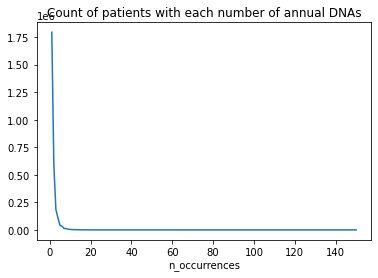

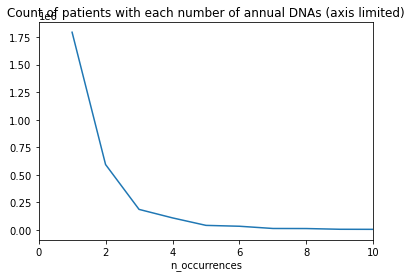

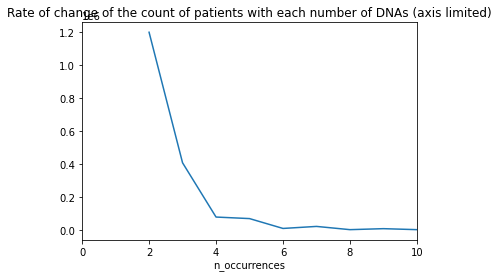

In [32]:
x_lim = 10

# Unbounded plot of the count of patients with each number of DNAs
matplotlib.pyplot.plot(
        fs_manyDNA['n_occurrences']
         ,fs_manyDNA['n_patients_with_n_occurrences_in_a_year']
        )
matplotlib.pyplot.title('Count of patients with each number of annual DNAs')
matplotlib.pyplot.xlabel('n_occurrences')
matplotlib.pyplot.show()
# Bounded plot of the count of patients with each number of DNAs
matplotlib.pyplot.plot(
        fs_manyDNA['n_occurrences']
         ,fs_manyDNA['n_patients_with_n_occurrences_in_a_year']
        )
matplotlib.pyplot.title('Count of patients with each number of annual DNAs (axis limited)')
matplotlib.pyplot.xlabel('n_occurrences')
matplotlib.pyplot.xlim([0, x_lim])
matplotlib.pyplot.show()
# Bounded plot of the rate of change of the count of patients with each number of DNAs (in other words, the difference between successive counts)
matplotlib.pyplot.plot(
         fs_manyDNA['n_occurrences'][1:]
         ,[i-j for i, j in zip(fs_manyDNA['n_patients_with_n_occurrences_in_a_year'][:-1], fs_manyDNA['n_patients_with_n_occurrences_in_a_year'][1:])]
        )
matplotlib.pyplot.title('Rate of change of the count of patients with each number of DNAs (axis limited)')
matplotlib.pyplot.xlabel('n_occurrences')
matplotlib.pyplot.xlim([0, x_lim])
matplotlib.pyplot.show()

# Rational for the threshold we used for 'recurrentEDattendance'
The threshold for what constitutes "recurrent" in the definition of 'recurrentEDattendance' was based on an investigation into the tallies of attendances at the emergency department within a year (i.e. 365 days), in patients' records.

The BigQuery syntax returns a Python pandas.DataFrame containing this count, `cnt_annual_ED_attedence`.


In [34]:
sql = \
"""
WITH
tbl_a AS (
  SELECT
    person_id
    ,tbl_ae_start_date AS visit_date
    ,LAG(tbl_ae_start_date) OVER(PARTITION BY person_id ORDER BY tbl_ae_start_date) AS lag_visit_date 
  FROM
    `""" + server_id + """.CB_FDM_Warehouse_V2.tbl_ae`
)
,tbl_b AS (
  SELECT
    person_id
    ,COUNT(person_id) AS cnt_annual_ED_attendence
  FROM
    tbl_a
  WHERE
    DATE_DIFF(visit_date, lag_visit_date, DAY) BETWEEN 1 AND 365
  GROUP BY
    person_id
)
SELECT
  person_id
  ,cnt_annual_ED_attendence
FROM
  tbl_b
WHERE
  cnt_annual_ED_attendence BETWEEN 3 AND 100
ORDER BY
      cnt_annual_ED_attendence
"""

fs_recurrentEDattednances = client.query(sql).to_dataframe()

fs_recurrentEDattednancesBelow is a histograme of the frequency of patients' annual count of ED attendances that suggests:

- Most patients have 4 or fewer ED attendances within a year.
- The bulk of the histogram occurs within 20 of fewer ED attendences.
- Few patients have annual ED attendance counts greater than 20.

</br>
</br>

__We decided that there are three cohorts, defined as:__
- 'Infrequent user' - four or fewer ED attendences within a year.
- 'Frequent user' - between five and twenty ED attendences within a year.
- 'Very frequent user' - more than twenty ED attendences within a year.

These criteria define the three values for the `recurrentEDattendance` variable.


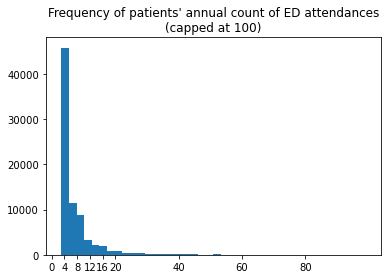

In [35]:
matplotlib.pyplot.hist(
    fs_recurrentEDattednances['cnt_annual_ED_attendence']
    ,bins = 40
)
matplotlib.pyplot.title('Frequency of patients\' annual count of ED attendances\n(capped at 100)')
matplotlib.pyplot.xticks(
        numpy.concatenate((numpy.arange(0, 19, 4), numpy.arange(20, 100, 20)))
)
matplotlib.pyplot.show()

# Rational for the threshold we used for 'categoryAnnualCountUniqueAntidepressants'
We needed to define categories for categoryAnnualCountUniqueAntidepressants because the counts can be too large for our planned analysis. We decided our categories based on an investigation into the counts of unique antidepressants that patients in the database were prescribed.

</br>
</br>
Below is a histograme of the frequency of patients' count of unique antidepressants that suggests:

- Most patients do not have a prescription for antidepressants.
- Of those identified as having a prescription for antidepressants, most were only prescribed one.
- Few patients are prescribed four or more antidepressants.
- Relatively very few are prescribed more than four.

</br>
</br>

__We decided that there are three cohorts, defined as:__
- 'No antidepressants' - zero antidepressants prescriptions.
- 'Few antidepressants' - between one and three unique antidepressants.
- 'Many antipressants' - four or more unique antidepressants.

These criteria define the three values for the `categoryAnnualCountUniqueAntidepressants` variable.


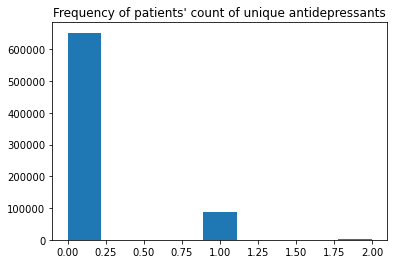

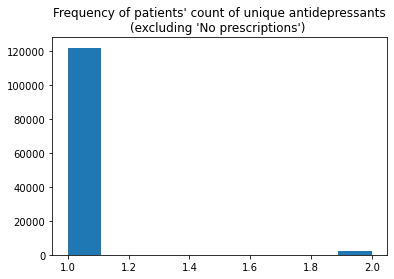

In [36]:
matplotlib.pyplot.hist(
    fs_clinician['categoryAnnualCountUniqueAntidepressants']
    ,bins = 9
)
matplotlib.pyplot.title('Frequency of patients\' count of unique antidepressants')
matplotlib.pyplot.show()

matplotlib.pyplot.hist(
    fs_uniqueAntidepressants['categoryAnnualCountUniqueAntidepressants']
    ,bins = 9
)
matplotlib.pyplot.title('Frequency of patients\' count of unique antidepressants\n(excluding \'No prescriptions\') ')
matplotlib.pyplot.show()